## Import data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression


from custom_functions import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Import dataset that was cleaned and prepared in Data Preparation notebook

In [2]:
conn = sqlite3.connect('../../data/processed/main.db')
query = '''SELECT * FROM step2_encoded'''
df_main = pd.read_sql(query, conn, index_col='index').reset_index(drop=True)
conn.close()

y = 'SalePrice'
y_log = 'SalePrice_log'

# One-hot encode categoricals

#### Encode "HeatSystem"

In [3]:
# First, convert encoded values to text values so we can understand their meaning
keys = get_lookups(108)
print('Keys:', keys)
convert_to_keys = lambda x: keys[str(int(x))].replace(" ", "").replace('-','') if x!='0' else 'Other'
heating = df_main.HeatSystem.apply(convert_to_keys)
#print('Original breakdown:\n{}'.format(heating.value_counts()))

# We see that Gravity and Radiant are very uncommon. Let's lump them into the "Other" category
simplify = lambda x: 'Other' if x in ['Gravity'] else x # possibly include Radiant
heating = heating.apply(simplify)
#print('Improved categorization:\n{}'.format(heating.value_counts()))

# Now that we have appropriate categorization, let's one-hot encode
heating_dummies = pd.get_dummies(heating, prefix='Heating', drop_first=False).drop('Heating_ForcedAir', axis=1) # Choose to drop ForcedAir

#Adjust df_main accordingly
df_main.drop('HeatSystem', axis=1, inplace=True)
df_main = pd.concat([df_main, heating_dummies], axis=1)

Keys: {'1': 'Floor-Wall', '2': 'Gravity', '3': 'Radiant', '4': 'Elec BB', '5': 'Forced Air', '6': 'Hot Water', '7': 'Heat Pump', '8': 'Other'}


#### Encode "Condition"

In [4]:
keys = get_lookups(83)
print('Keys:', keys)
convert_to_keys = lambda x: keys[x].replace(' ', '')
condition = df_main.Condition.apply(convert_to_keys)
#print('\nBreakdown of conditions:\n{}'.format(condition.value_counts()))

condition_dummies = pd.get_dummies(condition, prefix='Condition', drop_first=False).drop('Condition_Average', axis=1)
df_main.drop('Condition', axis=1, inplace=True)
df_main = pd.concat([df_main, condition_dummies], axis=1)

Keys: {'1': 'Poor', '2': 'Fair', '3': 'Average', '4': 'Good', '5': 'Very Good'}


#### Encode "HeatSource"

In [5]:
keys = get_lookups(84)
apply_keys = lambda x: keys[x] if x!='0' else 'Other'
heat_source = df_main.HeatSource.apply(apply_keys)
#print('Original breakdown:\n{}'.format(heat_source.value_counts()))

# Now, combine the extremely small categories into an 'Other' bucket
simplify = lambda x: 'Other' if x in ['Gas/Solar', 'Electricity/Solar', 'Oil/Solar'] else x
heat_source = heat_source.apply(simplify)
#print('Improved categorization:\n{}'.format(heat_source.value_counts()))

heat_source_dummies = pd.get_dummies(heat_source, prefix='HeatSource', drop_first=False).drop('HeatSource_Gas', axis=1)

# Adjust df_main with results
df_main.drop('HeatSource', axis=1, inplace=True)
df_main = pd.concat([df_main, heat_source_dummies], axis=1)

#### Encode porch metrics

By default, the information given about porches is given in square feet. Instead of looking at the impact of porch size, we will investigate whether the presence of a deck impacts SalePrice

Encode as either enclosed, open, both, or neither. The default will be "neither", and as a result we will drop that column once encoded.

In [6]:
porches = df_main[['SqFtOpenPorch', 'SqFtEnclosedPorch']].copy()
porches.columns = ['Open', 'Encl']

classify_porches = lambda x: 'Both' if ((x.Open>0)&(x.Encl>0)) else 'Open' if x.Open>0 else 'Closed' if x.Encl>0 else 'None'

porches['Porch'] = porches.apply(classify_porches, axis=1)
porches_dummies = pd.get_dummies(porches['Porch'], prefix='Porch', drop_first=False).drop('Porch_None', axis=1)

df_main = pd.concat([df_main, porches_dummies], axis=1)
df_main.drop(['SqFtOpenPorch', 'SqFtEnclosedPorch'], axis=1, inplace=True)
porches['Porch'].value_counts();

#### Create one-hot column for whether a home has been renovated

In [7]:
#df_main.loc[df_main.YrRenovated>0, 'YrRenovated'].hist()
encode = lambda x: 1 if x>0 else 0
df_main['Renovated'] = df_main.YrRenovated.apply(encode)

#### Create one-hot column for whether there is a garage and deck

In [8]:
#plt.hist(df_main.SqFtGarageAttached)
encode = lambda x: 1 if x>0 else 0
df_main['Garage'] = df_main.SqFtGarageAttached.apply(encode)
#df_main.Garage.value_counts()

In [9]:
#plt.hist(df_main.SqFtDeck)
encode = lambda x: 1 if x>0 else 0
df_main['Deck'] = df_main.SqFtDeck.apply(encode)
#df_main.Deck.value_counts()

#### Indicate whether or not basement is finished

In [10]:
# basement = df_main[['SqFtFinBasement', 'SqFtUnfinBasement']].copy()
# basement.columns = ['fin', 'unfin']
# classify_basements = lambda x: 'Unfinished' if ((x.fin>0)&(x.unfin>0)) else 'Finished' if x.fin>0 else 'Unfinished' if x.unfin>0 else 'None'
# basement['Simplified'] = basement.apply(classify_basements, axis=1)
# #print(basement.Simplified.value_counts())
# basement_dummies = pd.get_dummies(basement.Simplified, prefix='Basement', drop_first=False).drop('Basement_None', axis=1)
# df_main = pd.concat([df_main, basement_dummies], axis=1)

In [11]:
basement = df_main[['SqFtFinBasement', 'SqFtUnfinBasement']].copy()
basement.columns = ['fin', 'unfin']
classify_basements = lambda x: 'Unfinished' if ((x.fin>0)&(x.unfin>0)) else 'Finished' if x.fin>0 else 'Unfinished' if x.unfin>0 else 'None'
basement['Simplified'] = basement.apply(classify_basements, axis=1)
#print(basement.Simplified.value_counts())
basement_dummies = pd.get_dummies(basement.Simplified, prefix='Basement', drop_first=False).drop('Basement_Unfinished', axis=1)
df_main = pd.concat([df_main, basement_dummies], axis=1)


# Gain graphical understanding of data
Goal: find the best feature to start the model with. Start with continuous feature

In [12]:
df_main

,SalePrice,NbrLivingUnits,Stories,BldgGrade,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,FinBasementGrade,SqFtGarageBasement,SqFtGarageAttached,SqFtDeck,BrickStone,Bedrooms,YrBuilt,YrRenovated,SqFtUnfinBasement,SqFtUnfinished,Bathrooms,Fireplaces,Heating_ElecBB,Heating_FloorWall,Heating_HeatPump,Heating_HotWater,Heating_Other,Heating_Radiant,Condition_Fair,Condition_Good,Condition_Poor,Condition_VeryGood,HeatSource_Electricity,HeatSource_Oil,HeatSource_Other,Porch_Both,Porch_Closed,Porch_Open,Renovated,Garage,Deck,Basement_Finished,Basement_None
0,445000,1,1.0,7,1480,0,0,0,0,440,120,0,3,1994,0,0,0,2.00,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,1
1,188500,1,1.0,5,550,0,0,0,0,0,0,0,2,1942,0,0,0,0.75,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,730000,1,2.0,9,1540,380,285,8,0,0,155,0,3,1984,0,95,0,2.25,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,1055700,1,1.0,8,2780,1390,1390,7,0,0,100,0,6,1967,0,0,0,1.75,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
4,565000,1,1.0,8,2230,1280,880,7,400,80,100,0,3,2015,0,400,0,2.00,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18138,391000,1,1.0,8,1910,620,620,8,0,0,100,0,3,1985,0,0,0,2.25,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0
18139,1535000,1,2.0,9,3220,0,0,0,0,630,0,0,4,2015,0,0,0,3.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
18140,309000,1,1.5,7,960,0,0,0,0,420,0,0,3,1959,0,0,0,1.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
18141,759990,1,2.0,8,2010,0,0,0,0,440,0,0,4,1987,0,0,0,2.50,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1


In [13]:
# Identify continous features for pair-plot
continuous_features = []
for col in df_main.columns:
    ct = df_main[col].value_counts().shape[0]
    if (type(df_main[col][0])==type(np.int64(1))) or (type(df_main[col][0])==type(np.float64(0))):
        continuous_features.append(col) if ct>10 else False

# SLOW but potentially powerful pair-plot
#sns.pairplot(df_main[continuous_features], kind='reg', diag_kind='kde', plot_kws={'line_kws':{'color':'g'}, 'scatter_kws': {'alpha': 0.3}});

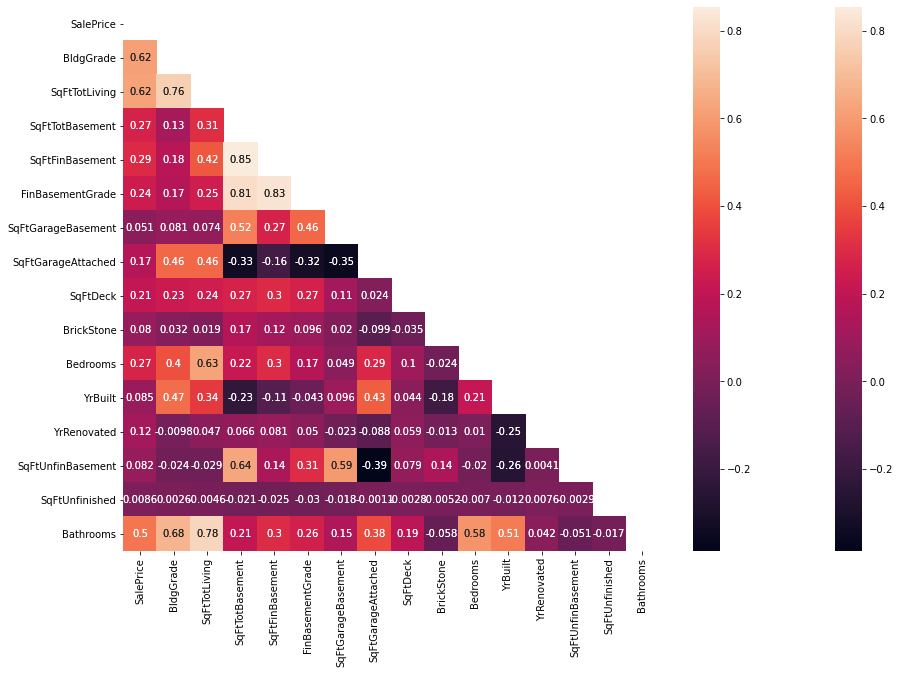

In [14]:
# Heatmap for continuous features
corr = df_main[continuous_features].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool)) # Formula taken from Flatiron School study group material
fig1, ax1 = plt.subplots(figsize=(15, 10))
sns.heatmap(corr, mask=mask, ax=ax1, annot=True);
sns.heatmap(corr, mask=mask, annot=True);

# Create the single-variable model

#### Start with the feature showing the largest correlation with SalePrice

In [15]:
# List correlations of SalePrice and input features
correlations = df_main.corr().stack().reset_index()
correlations = correlations.loc[(correlations.level_0 == 'SalePrice') & (correlations.level_1 != 'SalePrice')]
correlations.columns = ['Dependent', 'Feature', 'Correlation (abs)']
correlations['Correlation (abs)'] = correlations['Correlation (abs)'].abs()
correlations.sort_values(by='Correlation (abs)', ascending=False, inplace=True, ignore_index=True)
correlations.head()

,Dependent,Feature,Correlation (abs)
0,SalePrice,SqFtTotLiving,0.622001
1,SalePrice,BldgGrade,0.615589
2,SalePrice,Bathrooms,0.496065
3,SalePrice,Fireplaces,0.322830
4,SalePrice,SqFtFinBasement,0.293849


#### Not surprisingly, the livable square footage is amongst the highest predictors

Let's create the simple model and check the assumptions of Linear Regression. Let's also create a dataframe to store the model performance metrics so we can compare them as we go.

In [16]:
performance_metrics_cols = ['Y', 'X', 'Linearity p-value', 'Jarque-Bera (JB) metric', 'JB p-value', 'Lagrange multiplier', 'Lagrange multiplier p-value', 'F-score', 'F-score p-value', 'Average VIF', 'R^2 (Adj.)']
performance_metrics = pd.DataFrame(columns = performance_metrics_cols)

##### Model: **SqFtTotLiving**

Modeling: SalePrice ~ SqFtTotLiving
Linearity p-value (where null hypothesis = linear): 2.3498371777527503e-05
Normality of Residuals (where null hypothesis = normality): JB stat=13052071.633737946, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=9.69930890498894e-96 and f-value's p-value=7.370337506432815e-97
Variance Inflation Factors: NA (single variable)


,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852


<Figure size 432x288 with 0 Axes>

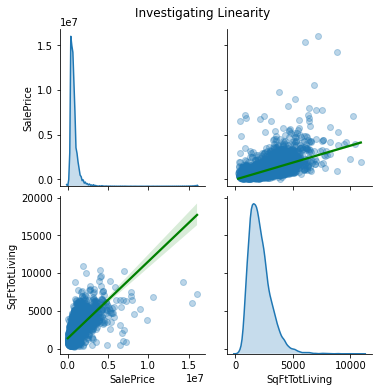

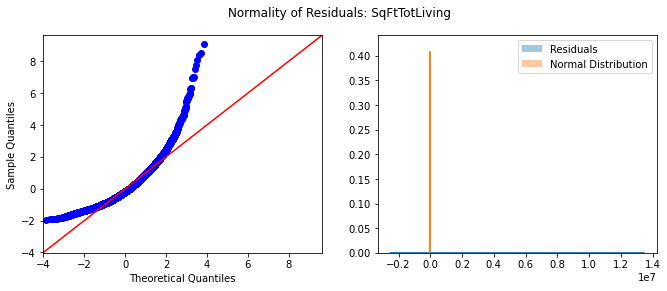

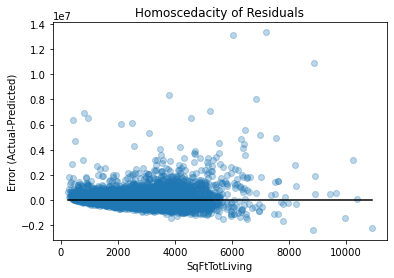

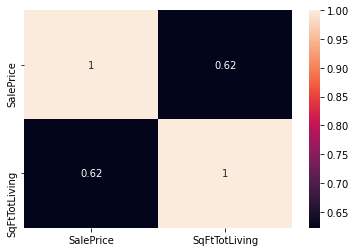

In [17]:
inputs = ['SqFtTotLiving']
output = y

model, df_model = produce_model(df_main, inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, feature_to_plot=inputs[0])
performance_metrics = performance_metrics.append(results)
performance_metrics

##### Clearly, neither SalePrice or SqFtTotLiving are linear. Let's **log-transform** and see the effect

In [18]:
log_transform = lambda x: np.log(x)    
df_main['SalePrice_log'] = df_main.SalePrice.apply(log_transform)
df_main['SqFtTotLiving_log'] = df_main.SqFtTotLiving.apply(log_transform)

##### Model: **SqFtTotLiving_log**

Modeling: SalePrice_log ~ SqFtTotLiving_log
Linearity p-value (where null hypothesis = linear): 0.3703812547440292
Normality of Residuals (where null hypothesis = normality): JB stat=5847.875160837674, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=0.0004431379335184857 and f-value's p-value=0.0004425453618993503
Variance Inflation Factors: NA (single variable)


,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log,SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006


<Figure size 432x288 with 0 Axes>

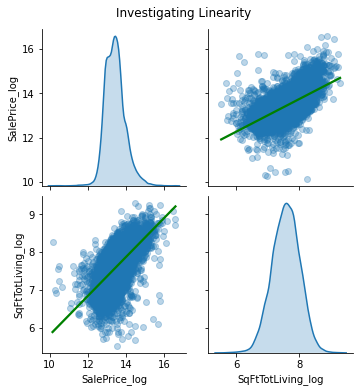

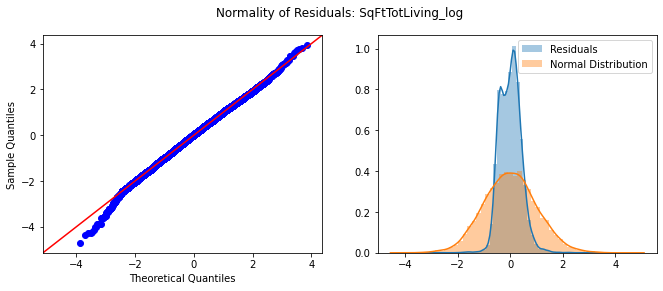

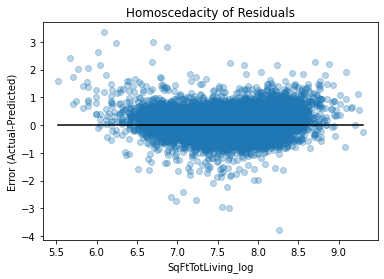

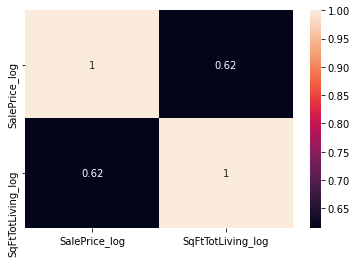

In [19]:
inputs = ['SqFtTotLiving_log']
output = y_log

model, df_model = produce_model(df_main, inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, feature_to_plot=inputs[0])
performance_metrics = performance_metrics.append(results)
performance_metrics

In [20]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                 1.107e+04
Date:                Thu, 11 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:24:30   Log-Likelihood:                -9628.3
No. Observations:               18143   AIC:                         1.926e+04
Df Residuals:                   18141   BIC:                         1.928e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.8661      0.053    148.411      0.000       7.762       7.970
SqFtTotLiving_log     0.7348      0.007    105.230      0.000       0.721       0.748
==============================================================================
Omnibus:                     1325.115   Durbin-Watson:                   1.676
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5847.875
Skew:                           0.225   Prob(JB):                         0.00
Kurtosis:                       5.745   Cond. No.                         134.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### This looks much better. Let's see which other features would be best to add using **RFE**

In [21]:
inputs = df_main.drop(['SalePrice_log'], axis=1)
output = df_main.SalePrice_log
recursive_feature_elimination(inputs, output, 15)

,NbrLivingUnits,BldgGrade,Heating_FloorWall,Heating_HotWater,Heating_Other,Heating_Radiant,Condition_Poor,Condition_VeryGood,HeatSource_Oil,HeatSource_Other,Porch_Both,Renovated,Garage,Basement_None,SqFtTotLiving_log
0,1,7,0,0,0,0,0,1,0,0,0,0,1,1,7.299797
1,1,5,1,0,0,0,0,0,1,0,0,0,0,1,6.309918
2,1,9,1,0,0,0,0,0,0,0,0,0,0,0,7.339538
3,1,8,0,0,0,0,0,0,0,0,0,0,0,0,7.930206
4,1,8,0,0,0,0,0,0,0,0,0,0,1,0,7.709757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18138,1,8,0,0,0,0,0,0,0,0,0,0,0,0,7.554859
18139,1,9,0,0,0,0,0,0,0,0,0,0,1,1,8.077137
18140,1,7,0,0,0,0,0,0,0,0,0,0,1,1,6.866933
18141,1,8,0,0,0,0,0,0,0,0,0,0,1,1,7.605890


Porch Open/Closed/Both metrics are the list (one-hot encoded). Let's add those to the model and see the impact. 

Model: **SqFtTotLiving_log, Porch**

In [22]:
inputs = ['SqFtTotLiving_log', 'Porch_Open', 'Porch_Closed', 'Porch_Both']
output = y_log

model, df_model = produce_model(df_main, inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, feature_to_plot=False)
performance_metrics = performance_metrics.append(results)
performance_metrics

Modeling: SalePrice_log ~ SqFtTotLiving_log+Porch_Open+Porch_Closed+Porch_Both
Linearity p-value (where null hypothesis = linear): 0.396849205969695
Normality of Residuals (where null hypothesis = normality): JB stat=6072.495254632473, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=0.002001362512587015 and f-value's p-value=0.0019976394941454392
Variance Inflation Factors:
              Feature       VIF
0  SqFtTotLiving_log  2.185786
1         Porch_Open  2.099455
2       Porch_Closed  1.047774
3         Porch_Both  1.038557


,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log,SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006
0,SalePrice_log,SqFtTotLiving_log+Porch_Open+Porch_Closed+Porc...,0.396849,6.072495e+03,0.0,16.922235,2.001363e-03,4.233341,1.997639e-03,1.59289,0.381865


In [23]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     2803.
Date:                Thu, 11 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:24:31   Log-Likelihood:                -9584.9
No. Observations:               18143   AIC:                         1.918e+04
Df Residuals:                   18138   BIC:                         1.922e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.8984      0.055    143.117      0.000       7.790       8.007
SqFtTotLiving_log     0.7279      0.007     98.419      0.000       0.713       0.742
Porch_Open            0.0302      0.007      4.593      0.000       0.017       0.043
Porch_Closed          0.1130      0.020      5.521      0.000       0.073       0.153
Porch_Both            0.1635      0.023      7.103      0.000       0.118       0.209
==============================================================================
Omnibus:                     1348.778   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6072.495
Skew:                           0.226   Prob(JB):                         0.00
Kurtosis:                       5.798   Cond. No.                         140.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Overall, a positive addition, though not one that makes a huge difference. Let's see what other attributes could be valauble to add. 

Note that BldgGrade was on the list previously, but we previously saw in the HeatMap that it has a very strong correlation with SqFtTotLiving. Let's not add it to the model so as to avoid colinearity. 

In [24]:
inputs = df_main.drop(['SalePrice_log', 'BldgGrade', 'SalePrice'], axis=1)
output = df_main.SalePrice_log
recursive_feature_elimination(inputs, output, 15).head(2)

,Stories,SqFtTotBasement,SqFtFinBasement,Bedrooms,SqFtUnfinBasement,Bathrooms,Heating_HotWater,Heating_Other,Heating_Radiant,Condition_Poor,HeatSource_Other,Renovated,Garage,Basement_Finished,SqFtTotLiving_log
0,1.0,0,0,3,0,2.00,0,0,0,0,0,0,1,0,7.299797
1,1.0,0,0,2,0,0.75,0,0,0,0,0,0,0,0,6.309918


We see that the one-hot encoded "Basement_Finished", corresponding to whether or not a basement has been finished, for homes with a basement is on the list. Let's investigate.

##### Model: **SqFtTotLiving_log, Porch, Basement_Finished**

In [25]:
inputs = ['SqFtTotLiving_log', 'Basement_Finished', 'Porch_Open', 'Porch_Closed', 'Porch_Both']
output = y_log

model, df_model = produce_model(df_main, inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, feature_to_plot=False)
performance_metrics = performance_metrics.append(results)
performance_metrics

Modeling: SalePrice_log ~ SqFtTotLiving_log+Basement_Finished+Porch_Open+Porch_Closed+Porch_Both
Linearity p-value (where null hypothesis = linear): 0.38458855874054304
Normality of Residuals (where null hypothesis = normality): JB stat=6088.399769384296, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=0.0014239293439633415 and f-value's p-value=0.001420365552671454
Variance Inflation Factors:
              Feature       VIF
0  SqFtTotLiving_log  2.373474
1  Basement_Finished  1.164058
2         Porch_Open  2.101665
3       Porch_Closed  1.047835
4         Porch_Both  1.038790


,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log,SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006
0,SalePrice_log,SqFtTotLiving_log+Porch_Open+Porch_Closed+Porc...,0.396849,6.072495e+03,0.0,16.922235,2.001363e-03,4.233341,1.997639e-03,1.59289,0.381865
0,SalePrice_log,SqFtTotLiving_log+Basement_Finished+Porch_Open...,0.384589,6.088400e+03,0.0,19.697670,1.423929e-03,3.942511,1.420366e-03,1.54516,0.384506


In [26]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     2268.
Date:                Thu, 11 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:24:32   Log-Likelihood:                -9545.6
No. Observations:               18143   AIC:                         1.910e+04
Df Residuals:                   18137   BIC:                         1.915e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.9964      0.056    142.373      0.000       7.886       8.106
SqFtTotLiving_log     0.7132      0.008     94.313      0.000       0.698       0.728
Basement_Finished     0.0817      0.009      8.879      0.000       0.064       0.100
Porch_Open            0.0353      0.007      5.348      0.000       0.022       0.048
Porch_Closed          0.1099      0.020      5.381      0.000       0.070       0.150
Porch_Both            0.1603      0.023      6.975      0.000       0.115       0.205
==============================================================================
Omnibus:                     1348.089   Durbin-Watson:                   1.682
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6088.400
Skew:                           0.224   Prob(JB):                         0.00
Kurtosis:                       5.802   Cond. No.                         143.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Aside from Lagrange multiplier going up slightly, there wasn't much change. However, it does given us some statistically significant findings about finishing a garage, so that's progress. We'll leave interpretation for later.

Use **RFE** to find other valuable additions. Since we already have info about the Basement being finished, let's leave that out.

In [27]:
inputs = df_main.drop(['SalePrice_log', 'BldgGrade', 'SalePrice', 'SqFtFinBasement', 'SqFtUnfinBasement'], axis=1)
output = df_main.SalePrice_log
recursive_feature_elimination(inputs, output, 10).head(2)

,Stories,Heating_HotWater,Heating_Other,Heating_Radiant,Condition_Poor,HeatSource_Other,Renovated,Garage,Basement_None,SqFtTotLiving_log
0,1.0,0,0,0,0,0,0,1,1,7.299797
1,1.0,0,0,0,0,0,0,0,1,6.309918


I'm curious to know more about the impact of having a garage. Recall that it is one-hot encoded, corresponding to whether one exists or not

##### Model: **SqFtTotLiving_log, Porch, Basement_Finished, Garage**

In [28]:
inputs = ['Garage','SqFtTotLiving_log', 'Basement_Finished', 'Porch_Open', 'Porch_Closed', 'Porch_Both']
output = y_log

model, df_model = produce_model(df_main, inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, feature_to_plot=False)
performance_metrics = performance_metrics.append(results)
performance_metrics

Modeling: SalePrice_log ~ Garage+SqFtTotLiving_log+Basement_Finished+Porch_Open+Porch_Closed+Porch_Both
Linearity p-value (where null hypothesis = linear): 0.6161468754177399
Normality of Residuals (where null hypothesis = normality): JB stat=7864.80088542309, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=2.997993001594192e-08 and f-value's p-value=2.9358996835358537e-08
Variance Inflation Factors:
              Feature       VIF
0             Garage  2.376794
1  SqFtTotLiving_log  3.499859
2  Basement_Finished  1.175025
3         Porch_Open  2.146827
4       Porch_Closed  1.052789
5         Porch_Both  1.046320


,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log,SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006
0,SalePrice_log,SqFtTotLiving_log+Porch_Open+Porch_Closed+Porc...,0.396849,6.072495e+03,0.0,16.922235,2.001363e-03,4.233341,1.997639e-03,1.59289,0.381865
0,SalePrice_log,SqFtTotLiving_log+Basement_Finished+Porch_Open...,0.384589,6.088400e+03,0.0,19.697670,1.423929e-03,3.942511,1.420366e-03,1.54516,0.384506
0,SalePrice_log,Garage+SqFtTotLiving_log+Basement_Finished+Por...,0.616147,7.864801e+03,0.0,45.972584,2.997993e-08,7.678598,2.935900e-08,1.88294,0.410694


In [29]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     2108.
Date:                Thu, 11 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:24:33   Log-Likelihood:                -9150.7
No. Observations:               18143   AIC:                         1.832e+04
Df Residuals:                   18136   BIC:                         1.837e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.6038      0.057    134.183      0.000       7.493       7.715
Garage               -0.1827      0.006    -28.407      0.000      -0.195      -0.170
SqFtTotLiving_log     0.7781      0.008    100.476      0.000       0.763       0.793
Basement_Finished     0.0440      0.009      4.831      0.000       0.026       0.062
Porch_Open            0.0489      0.006      7.554      0.000       0.036       0.062
Porch_Closed          0.0767      0.020      3.829      0.000       0.037       0.116
Porch_Both            0.1053      0.023      4.665      0.000       0.061       0.150
==============================================================================
Omnibus:                     1463.900   Durbin-Watson:                   1.717
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7864.801
Skew:                           0.183   Prob(JB):                         0.00
Kurtosis:                       6.205   Cond. No.                         148.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

That is telling us that the presence of a garage is correlated with a significantly lower SalePrice. Huh. That's surprising. Let's look at Garage on a square-footage basis instead.
##### Model: **SqFtTotLiving_log, Porch, Basement_Finished, SqFtGarage**

In [30]:
inputs = ['SqFtGarageAttached','SqFtTotLiving_log', 'Basement_Finished', 'Porch_Open', 'Porch_Closed', 'Porch_Both']
output = y_log

model, df_model = produce_model(df_main, inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, feature_to_plot=False)
performance_metrics = performance_metrics.append(results)
performance_metrics

Modeling: SalePrice_log ~ SqFtGarageAttached+SqFtTotLiving_log+Basement_Finished+Porch_Open+Porch_Closed+Porch_Both
Linearity p-value (where null hypothesis = linear): 0.40121567939128333
Normality of Residuals (where null hypothesis = normality): JB stat=7059.184517964778, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=0.0009030716247350228 and f-value's p-value=0.0009000630497107614
Variance Inflation Factors:
               Feature       VIF
0  SqFtGarageAttached  2.075221
1   SqFtTotLiving_log  3.036601
2   Basement_Finished  1.169634
3          Porch_Open  2.207461
4        Porch_Closed  1.050701
5          Porch_Both  1.041841


,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log,SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006
0,SalePrice_log,SqFtTotLiving_log+Porch_Open+Porch_Closed+Porc...,0.396849,6.072495e+03,0.0,16.922235,2.001363e-03,4.233341,1.997639e-03,1.59289,0.381865
0,SalePrice_log,SqFtTotLiving_log+Basement_Finished+Porch_Open...,0.384589,6.088400e+03,0.0,19.697670,1.423929e-03,3.942511,1.420366e-03,1.54516,0.384506
0,SalePrice_log,Garage+SqFtTotLiving_log+Basement_Finished+Por...,0.616147,7.864801e+03,0.0,45.972584,2.997993e-08,7.678598,2.935900e-08,1.88294,0.410694
0,SalePrice_log,SqFtGarageAttached+SqFtTotLiving_log+Basement_...,0.401216,7.059185e+03,0.0,22.700974,9.030716e-04,3.786774,9.000630e-04,1.76358,0.395412


In [31]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     1979.
Date:                Thu, 11 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:24:33   Log-Likelihood:                -9382.9
No. Observations:               18143   AIC:                         1.878e+04
Df Residuals:                   18136   BIC:                         1.883e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              7.5864      0.060    126.250      0.000       7.469       7.704
SqFtGarageAttached    -0.0002   1.18e-05    -18.115      0.000      -0.000      -0.000
SqFtTotLiving_log      0.7746      0.008     94.179      0.000       0.758       0.791
Basement_Finished      0.0564      0.009      6.113      0.000       0.038       0.075
Porch_Open             0.0492      0.007      7.481      0.000       0.036       0.062
Porch_Closed           0.0965      0.020      4.763      0.000       0.057       0.136
Porch_Both             0.1373      0.023      6.018      0.000       0.093       0.182
==============================================================================
Omnibus:                     1422.778   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7059.185
Skew:                           0.209   Prob(JB):                         0.00
Kurtosis:                       6.027   Cond. No.                     7.97e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.97e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The findings are inconsequential. Looking at the distribution of the SqFtGarageAttached data, it looks like a log transformation could provide powerful insight. However, keep in mind that there are many homes without garages, leaving us with *log(0)*, which gives us an error. We'll instead add a small number to the whole feature such that all values are positive. This inherently introduces error, but with a small additive value, the additional error is very small. 
##### **Log transform** SqFtGarageAttached

In [32]:
add_then_log_transform = lambda x: np.log(x+1)    
df_main['SqFtGarageAttached_log'] = df_main.SalePrice.apply(add_then_log_transform)

##### Model: **SqFtTotLiving_log, Porch, Basement_Finished, SqFtGarage_log**

In [33]:
inputs = ['SqFtGarageAttached_log','SqFtTotLiving_log', 'Basement_Finished', 'Porch_Open', 'Porch_Closed', 'Porch_Both']
output = y_log

model, df_model = produce_model(df_main, inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, feature_to_plot=False)
performance_metrics = performance_metrics.append(results)
performance_metrics

Modeling: SalePrice_log ~ SqFtGarageAttached_log+SqFtTotLiving_log+Basement_Finished+Porch_Open+Porch_Closed+Porch_Both
Linearity p-value (where null hypothesis = linear): 0.9999999999999999
Normality of Residuals (where null hypothesis = normality): JB stat=986120388.025805, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=1.0074479410399614e-79 and f-value's p-value=1.3896292799007486e-80
Variance Inflation Factors:
                   Feature         VIF
0  SqFtGarageAttached_log  509.010648
1       SqFtTotLiving_log  520.063846
2       Basement_Finished    1.175548
3              Porch_Open    2.173356
4            Porch_Closed    1.051983
5              Porch_Both    1.040491


,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log,SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006
0,SalePrice_log,SqFtTotLiving_log+Porch_Open+Porch_Closed+Porc...,0.396849,6.072495e+03,0.0,16.922235,2.001363e-03,4.233341,1.997639e-03,1.59289,0.381865
0,SalePrice_log,SqFtTotLiving_log+Basement_Finished+Porch_Open...,0.384589,6.088400e+03,0.0,19.697670,1.423929e-03,3.942511,1.420366e-03,1.54516,0.384506
0,SalePrice_log,Garage+SqFtTotLiving_log+Basement_Finished+Por...,0.616147,7.864801e+03,0.0,45.972584,2.997993e-08,7.678598,2.935900e-08,1.88294,0.410694
0,SalePrice_log,SqFtGarageAttached+SqFtTotLiving_log+Basement_...,0.401216,7.059185e+03,0.0,22.700974,9.030716e-04,3.786774,9.000630e-04,1.76358,0.395412
0,SalePrice_log,SqFtGarageAttached_log+SqFtTotLiving_log+Basem...,1.000000,9.861204e+08,0.0,383.452446,1.007448e-79,65.263427,1.389629e-80,172.419,1.000000


Nope. That gives hugely colinear data bwith SqFtTotLiving_log. Since we want to compare the value of a garage and a bedroom, let's ignore garage square footage, keep the one-hot garage metric, and add in the **Bedrooms**
##### Model: **SqFtTotLiving_log, Porch, Basement_Finished, Bedrooms**

In [34]:
inputs = ['Bedrooms','SqFtTotLiving_log', 'Basement_Finished', 'Porch_Open', 'Porch_Closed', 'Porch_Both']
output = y_log

model, df_model = produce_model(df_main, inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, feature_to_plot=False)
performance_metrics = performance_metrics.append(results)
performance_metrics

Modeling: SalePrice_log ~ Bedrooms+SqFtTotLiving_log+Basement_Finished+Porch_Open+Porch_Closed+Porch_Both
Linearity p-value (where null hypothesis = linear): 0.5092401575694254
Normality of Residuals (where null hypothesis = normality): JB stat=5998.897090759551, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=3.1365487148233e-10 and f-value's p-value=3.035016068567221e-10
Variance Inflation Factors:
              Feature        VIF
0           Bedrooms  20.294528
1  SqFtTotLiving_log  20.387028
2  Basement_Finished   1.176107
3         Porch_Open   2.127653
4       Porch_Closed   1.050055
5         Porch_Both   1.039356


,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log,SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006
0,SalePrice_log,SqFtTotLiving_log+Porch_Open+Porch_Closed+Porc...,0.396849,6.072495e+03,0.0,16.922235,2.001363e-03,4.233341,1.997639e-03,1.59289,0.381865
0,SalePrice_log,SqFtTotLiving_log+Basement_Finished+Porch_Open...,0.384589,6.088400e+03,0.0,19.697670,1.423929e-03,3.942511,1.420366e-03,1.54516,0.384506
0,SalePrice_log,Garage+SqFtTotLiving_log+Basement_Finished+Por...,0.616147,7.864801e+03,0.0,45.972584,2.997993e-08,7.678598,2.935900e-08,1.88294,0.410694
0,SalePrice_log,SqFtGarageAttached+SqFtTotLiving_log+Basement_...,0.401216,7.059185e+03,0.0,22.700974,9.030716e-04,3.786774,9.000630e-04,1.76358,0.395412
0,SalePrice_log,SqFtGarageAttached_log+SqFtTotLiving_log+Basem...,1.000000,9.861204e+08,0.0,383.452446,1.007448e-79,65.263427,1.389629e-80,172.419,1.000000
0,SalePrice_log,Bedrooms+SqFtTotLiving_log+Basement_Finished+P...,0.509240,5.998897e+03,0.0,55.839661,3.136549e-10,9.331740,3.035016e-10,7.67912,0.397006


The colinearity with SqFtTotLiving and Bedrooms is too high. Let's get rid of SqFtTotLiving_Log and try again.
##### Model: **Porch, Basement_Finished, Bedrooms, Garage**

Modeling: SalePrice_log ~ Bedrooms_cut+Garage+Basement_Finished+Porch_Open+Porch_Closed+Porch_Both
Linearity p-value (where null hypothesis = linear): 0.04800824129390376
Normality of Residuals (where null hypothesis = normality): JB stat=3328.019156897556, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=2.553684145676509e-23 and f-value's p-value=2.1401413012583983e-23
Variance Inflation Factors:
              Feature       VIF
0       Bedrooms_cut  3.599239
1             Garage  2.467970
2  Basement_Finished  1.180869
3         Porch_Open  2.122434
4       Porch_Closed  1.041267
5         Porch_Both  1.038672


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     541.2
Date:                Thu, 11 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:24:35   Log-Likelihood:                -12068.
No. Observations:               17853   AIC:                         2.415e+04
Df Residuals:                   17846   BIC:                         2.420e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            12.7404      0.015    856.877      0.000      12.711      12.770
Bedrooms_cut          0.1772      0.004     39.520      0.000       0.168       0.186
Garage               -0.0685      0.008     -9.006      0.000      -0.083      -0.054
Basement_Finished     0.2046      0.011     18.968      0.000       0.183       0.226
Porch_Open            0.1919      0.007     25.654      0.000       0.177       0.207
Porch_Closed          0.0738      0.024      3.091      0.002       0.027       0.121
Porch_Both            0.1718      0.027      6.366      0.000       0.119       0.225
==============================================================================
Omnibus:                     1243.465   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3328.019
Skew:                           0.395   Prob(JB):                         0.00
Kurtosis:                       4.962   Cond. No.                         28.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Figure size 432x288 with 0 Axes>

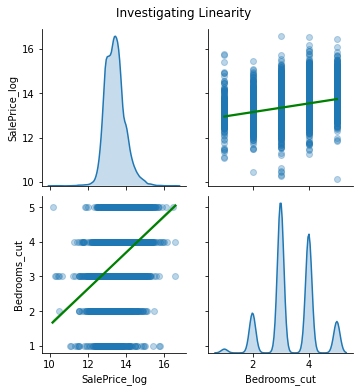

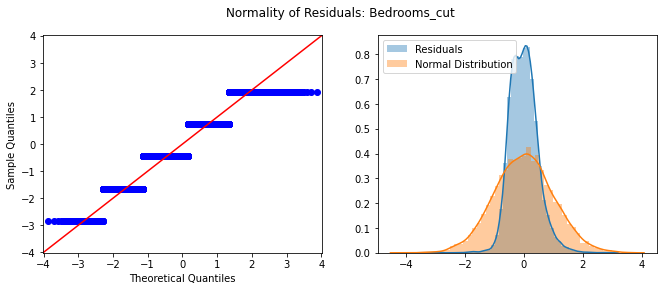

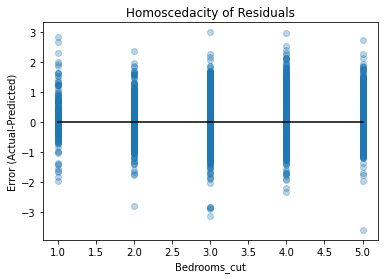

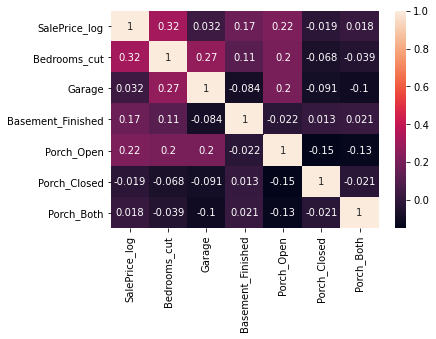

In [35]:
inputs = ['Bedrooms_cut','Garage', 'Basement_Finished', 'Porch_Open', 'Porch_Closed', 'Porch_Both']
output = y_log

df_main_cut = df_main.copy()
df_main_cut['Bedrooms_cut'] = cut_extremes(df_main_cut.Bedrooms, 3)

model, df_model = produce_model(df_main_cut.dropna(), inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, feature_to_plot='Bedrooms_cut')
performance_metrics = performance_metrics.append(results)
performance_metrics
model.summary()

Modeling: SalePrice_log ~ Bedrooms+Garage+Basement_Finished+Porch_Open+Porch_Closed+Porch_Both
Linearity p-value (where null hypothesis = linear): 0.11488920727504152
Normality of Residuals (where null hypothesis = normality): JB stat=3425.225585466073, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=1.867536178260445e-26 and f-value's p-value=1.493835295298829e-26
Variance Inflation Factors:
              Feature       VIF
0           Bedrooms  3.561271
1             Garage  2.429523
2  Basement_Finished  1.191574
3         Porch_Open  2.130405
4       Porch_Closed  1.039733
5         Porch_Both  1.038022


,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log,SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006
0,SalePrice_log,SqFtTotLiving_log+Porch_Open+Porch_Closed+Porc...,0.396849,6.072495e+03,0.0,16.922235,2.001363e-03,4.233341,1.997639e-03,1.59289,0.381865
0,SalePrice_log,SqFtTotLiving_log+Basement_Finished+Porch_Open...,0.384589,6.088400e+03,0.0,19.697670,1.423929e-03,3.942511,1.420366e-03,1.54516,0.384506
0,SalePrice_log,Garage+SqFtTotLiving_log+Basement_Finished+Por...,0.616147,7.864801e+03,0.0,45.972584,2.997993e-08,7.678598,2.935900e-08,1.88294,0.410694
0,SalePrice_log,SqFtGarageAttached+SqFtTotLiving_log+Basement_...,0.401216,7.059185e+03,0.0,22.700974,9.030716e-04,3.786774,9.000630e-04,1.76358,0.395412
0,SalePrice_log,SqFtGarageAttached_log+SqFtTotLiving_log+Basem...,1.000000,9.861204e+08,0.0,383.452446,1.007448e-79,65.263427,1.389629e-80,172.419,1.000000
0,SalePrice_log,Bedrooms+SqFtTotLiving_log+Basement_Finished+P...,0.509240,5.998897e+03,0.0,55.839661,3.136549e-10,9.331740,3.035016e-10,7.67912,0.397006
0,SalePrice_log,Bedrooms_cut+Garage+Basement_Finished+Porch_Op...,0.048008,3.328019e+03,0.0,119.071012,2.553684e-23,19.970582,2.140141e-23,1.90841,0.153656
0,SalePrice_log,Bedrooms+Garage+Basement_Finished+Porch_Open+P...,0.114889,3.425226e+03,0.0,133.976668,1.867536e-26,22.486883,1.493835e-26,1.89842,0.158000


<Figure size 432x288 with 0 Axes>

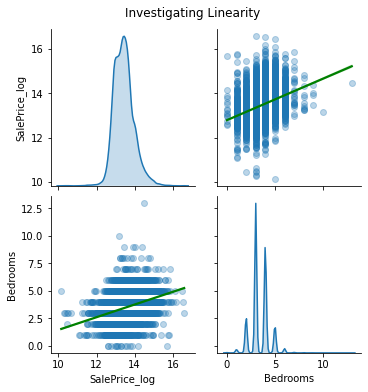

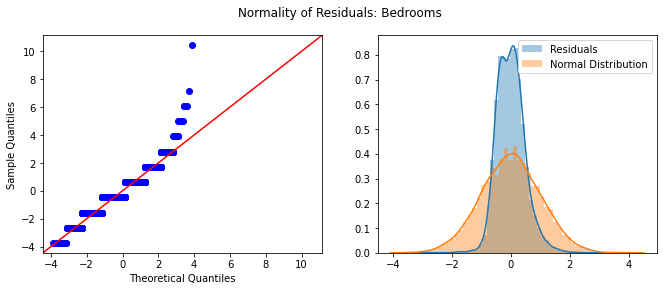

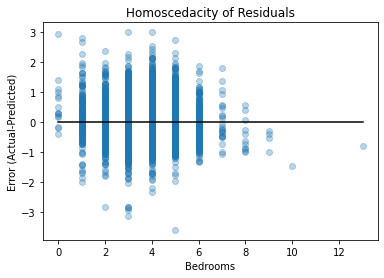

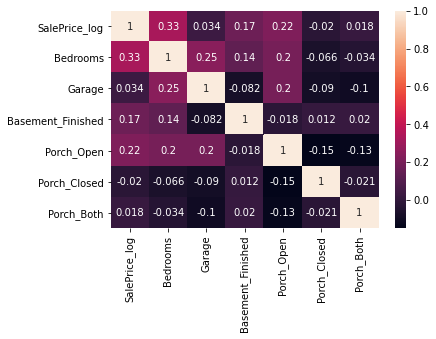

In [36]:
inputs = ['Bedrooms','Garage', 'Basement_Finished', 'Porch_Open', 'Porch_Closed', 'Porch_Both']
output = y_log

model, df_model = produce_model(df_main, inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, feature_to_plot='Bedrooms')
performance_metrics = performance_metrics.append(results)
performance_metrics

This makes every metric worse. 

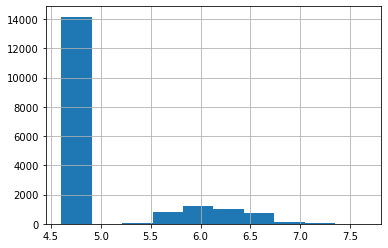

In [37]:
logx = lambda x: np.log(x+100)
(df_main.SqFtGarageBasement.apply(logx)).hist()

Modeling: SalePrice_log ~ Bedrooms_cut+SqFtGarageBasement+SqFtTotLiving_log+Basement_Finished+Porch_Open+Porch_Closed+Porch_Both
Linearity p-value (where null hypothesis = linear): 0.5173146939575205


C:\Users\seths\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


Normality of Residuals (where null hypothesis = normality): JB stat=5346.946957343359, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=9.55340925817975e-13 and f-value's p-value=9.036588334470291e-13
Variance Inflation Factors:
               Feature        VIF
0        Bedrooms_cut  23.463722
1  SqFtGarageBasement   1.295526
2   SqFtTotLiving_log  23.783803
3   Basement_Finished   1.212475
4          Porch_Open   2.159380
5        Porch_Closed   1.051120
6          Porch_Both   1.041221


,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log,SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006
0,SalePrice_log,SqFtTotLiving_log+Porch_Open+Porch_Closed+Porc...,0.396849,6.072495e+03,0.0,16.922235,2.001363e-03,4.233341,1.997639e-03,1.59289,0.381865
0,SalePrice_log,SqFtTotLiving_log+Basement_Finished+Porch_Open...,0.384589,6.088400e+03,0.0,19.697670,1.423929e-03,3.942511,1.420366e-03,1.54516,0.384506
0,SalePrice_log,Garage+SqFtTotLiving_log+Basement_Finished+Por...,0.616147,7.864801e+03,0.0,45.972584,2.997993e-08,7.678598,2.935900e-08,1.88294,0.410694
0,SalePrice_log,SqFtGarageAttached+SqFtTotLiving_log+Basement_...,0.401216,7.059185e+03,0.0,22.700974,9.030716e-04,3.786774,9.000630e-04,1.76358,0.395412
0,SalePrice_log,SqFtGarageAttached_log+SqFtTotLiving_log+Basem...,1.000000,9.861204e+08,0.0,383.452446,1.007448e-79,65.263427,1.389629e-80,172.419,1.000000
0,SalePrice_log,Bedrooms+SqFtTotLiving_log+Basement_Finished+P...,0.509240,5.998897e+03,0.0,55.839661,3.136549e-10,9.331740,3.035016e-10,7.67912,0.397006
0,SalePrice_log,Bedrooms_cut+Garage+Basement_Finished+Porch_Op...,0.048008,3.328019e+03,0.0,119.071012,2.553684e-23,19.970582,2.140141e-23,1.90841,0.153656
0,SalePrice_log,Bedrooms+Garage+Basement_Finished+Porch_Open+P...,0.114889,3.425226e+03,0.0,133.976668,1.867536e-26,22.486883,1.493835e-26,1.89842,0.158000


<Figure size 432x288 with 0 Axes>

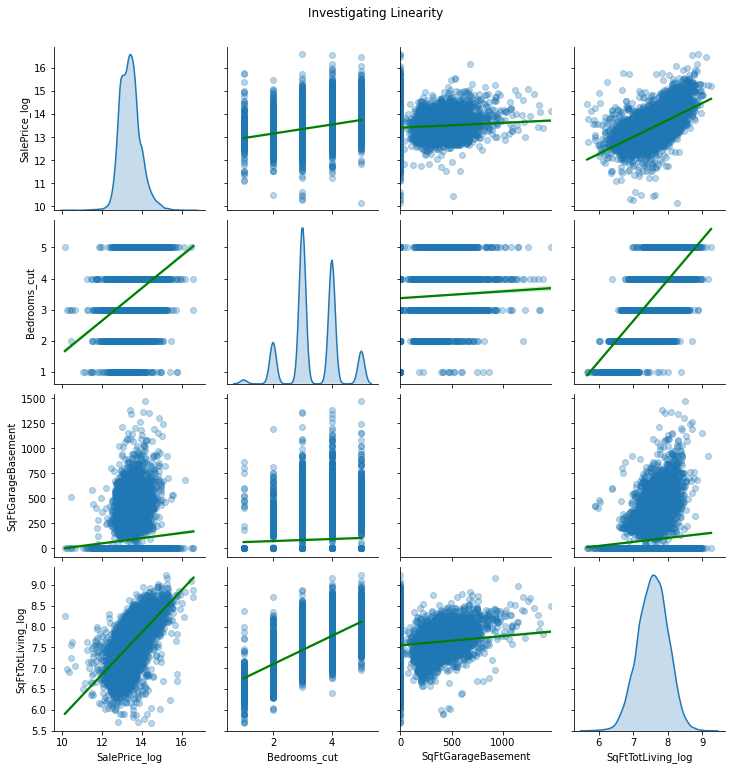

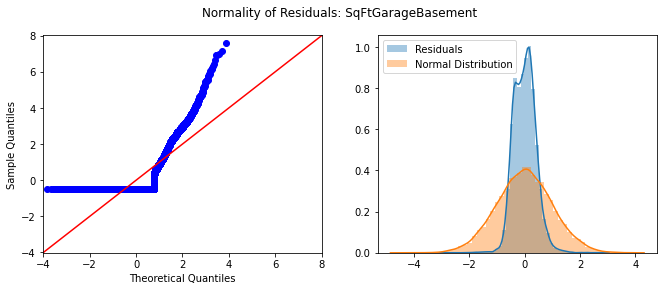

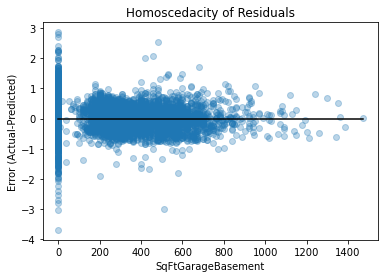

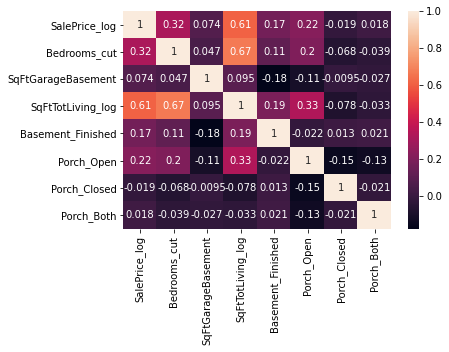

In [38]:
#plt.hist(df_main.SqFtGarageAttached)
encode = lambda x: 1 if x>0 else 0
df_main['GarageBasement'] = df_main.SqFtGarageBasement.apply(encode)
#df_main.Garage.value_counts()


inputs = ['Bedrooms_cut','SqFtGarageBasement', 'SqFtTotLiving_log', 'Basement_Finished', 'Porch_Open', 'Porch_Closed', 'Porch_Both']
output = y_log

model, df_model = produce_model(df_main_cut.dropna(), inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, feature_to_plot='SqFtGarageBasement')
performance_metrics = performance_metrics.append(results)
performance_metrics
#model.summary()

#sns.pairplot(df_main[inputs]);

#### It looks like it's time to move past Garage data. I don't see statistical significance in a model that passes the linear regression assumption tests

Let's isolate some more interesting features

In [39]:
inputs = df_main.drop(['SalePrice_log', 'BldgGrade', 'SalePrice', 'SqFtFinBasement', 'SqFtUnfinBasement'], axis=1)
output = df_main.SalePrice_log
recursive_feature_elimination(inputs, output, 10).head(2)

,Heating_ElecBB,Heating_FloorWall,Heating_HotWater,Heating_Other,Condition_Fair,Condition_Poor,HeatSource_Other,Renovated,SqFtTotLiving_log,SqFtGarageAttached_log
0,0,0,0,0,0,0,0,0,7.299797,13.005832
1,0,1,0,0,0,0,0,0,6.309918,12.146859


One-hot encoded versions of the heating method seem to be very relevant and strong contributors to a high R^2 model. Let's try adding them to the most functional model we have had so far. 
##### Model: **Heating** plus others. Recall that "Forced Air" is the default (dropped) column here

In [40]:
df_main.columns.sort_values()

Index(['Basement_Finished', 'Basement_None', 'Bathrooms', 'Bedrooms',
       'BldgGrade', 'BrickStone', 'Condition_Fair', 'Condition_Good',
       'Condition_Poor', 'Condition_VeryGood', 'Deck', 'FinBasementGrade',
       'Fireplaces', 'Garage', 'GarageBasement', 'HeatSource_Electricity',
       'HeatSource_Oil', 'HeatSource_Other', 'Heating_ElecBB',
       'Heating_FloorWall', 'Heating_HeatPump', 'Heating_HotWater',
       'Heating_Other', 'Heating_Radiant', 'NbrLivingUnits', 'Porch_Both',
       'Porch_Closed', 'Porch_Open', 'Renovated', 'SalePrice', 'SalePrice_log',
       'SqFtDeck', 'SqFtFinBasement', 'SqFtGarageAttached',
       'SqFtGarageAttached_log', 'SqFtGarageBasement', 'SqFtTotBasement',
       'SqFtTotLiving', 'SqFtTotLiving_log', 'SqFtUnfinBasement',
       'SqFtUnfinished', 'Stories', 'YrBuilt', 'YrRenovated'],
      dtype='object')

Modeling: SalePrice_log ~ Heating_ElecBB+Heating_FloorWall+Heating_HeatPump+Heating_HotWater+Heating_Radiant+SqFtTotLiving_log+Basement_Finished+Porch_Open+Porch_Closed+Porch_Both
Linearity p-value (where null hypothesis = linear): 0.40062660073591494
Normality of Residuals (where null hypothesis = normality): JB stat=6339.076132208505, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=0.010926519817467707 and f-value's p-value=0.010905285779376179
Variance Inflation Factors:
              Feature       VIF
0     Heating_ElecBB  1.078888
1  Heating_FloorWall  1.041766
2   Heating_HeatPump  1.118457
3   Heating_HotWater  1.035416
4    Heating_Radiant  1.018625
5  SqFtTotLiving_log  2.688416
6  Basement_Finished  1.173443
7         Porch_Open  2.126434
8       Porch_Closed  1.049286
9         Porch_Both  1.043348
                            OLS Regression Results                            
Dep. Variable:          SalePrice_log   R-squared:      

,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log,SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006
0,SalePrice_log,SqFtTotLiving_log+Porch_Open+Porch_Closed+Porc...,0.396849,6.072495e+03,0.0,16.922235,2.001363e-03,4.233341,1.997639e-03,1.59289,0.381865
0,SalePrice_log,SqFtTotLiving_log+Basement_Finished+Porch_Open...,0.384589,6.088400e+03,0.0,19.697670,1.423929e-03,3.942511,1.420366e-03,1.54516,0.384506
0,SalePrice_log,Garage+SqFtTotLiving_log+Basement_Finished+Por...,0.616147,7.864801e+03,0.0,45.972584,2.997993e-08,7.678598,2.935900e-08,1.88294,0.410694
0,SalePrice_log,SqFtGarageAttached+SqFtTotLiving_log+Basement_...,0.401216,7.059185e+03,0.0,22.700974,9.030716e-04,3.786774,9.000630e-04,1.76358,0.395412
0,SalePrice_log,SqFtGarageAttached_log+SqFtTotLiving_log+Basem...,1.000000,9.861204e+08,0.0,383.452446,1.007448e-79,65.263427,1.389629e-80,172.419,1.000000
0,SalePrice_log,Bedrooms+SqFtTotLiving_log+Basement_Finished+P...,0.509240,5.998897e+03,0.0,55.839661,3.136549e-10,9.331740,3.035016e-10,7.67912,0.397006
0,SalePrice_log,Bedrooms_cut+Garage+Basement_Finished+Porch_Op...,0.048008,3.328019e+03,0.0,119.071012,2.553684e-23,19.970582,2.140141e-23,1.90841,0.153656
0,SalePrice_log,Bedrooms+Garage+Basement_Finished+Porch_Open+P...,0.114889,3.425226e+03,0.0,133.976668,1.867536e-26,22.486883,1.493835e-26,1.89842,0.158000


<Figure size 432x288 with 0 Axes>

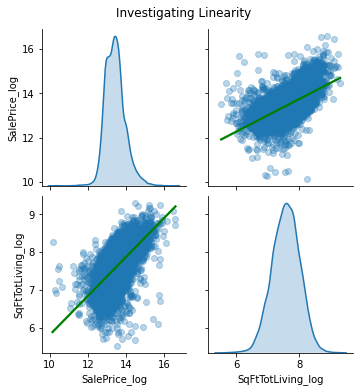

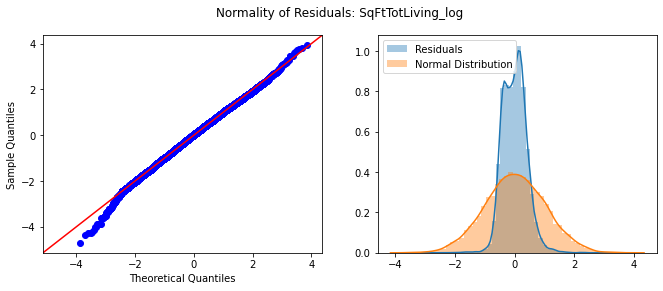

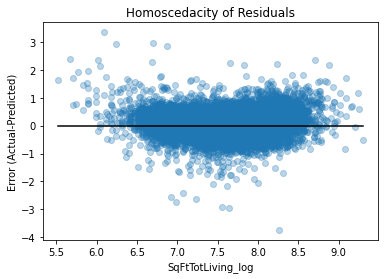

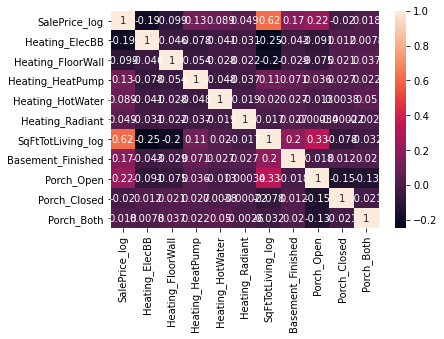

In [41]:
inputs = ['Heating_ElecBB', 'Heating_FloorWall', 'Heating_HeatPump', 'Heating_HotWater','Heating_Radiant', 'SqFtTotLiving_log', 'Basement_Finished', 'Porch_Open', 'Porch_Closed', 'Porch_Both']
output = y_log




model, df_model = produce_model(df_main, inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, feature_to_plot='SqFtTotLiving_log')
performance_metrics = performance_metrics.append(results)

print(model.summary())
performance_metrics


In [50]:
# ADDED 'RENOVATED' - CONCLUSION: ADDING RENOVATED MAKES IT WORSE. REMOVE.
inputs = ['Renovated','Heating_ElecBB', 'Heating_FloorWall', 'Heating_HeatPump', 'Heating_HotWater','Heating_Radiant', 'SqFtTotLiving_log', 'Basement_Finished', 'Porch_Open', 'Porch_Closed', 'Porch_Both']
output = y_log


model, df_model = produce_model(df_main, inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, feature_to_plot=False)
performance_metrics = performance_metrics.append(results)

print(model.summary())
performance_metrics

Modeling: SalePrice_log ~ Renovated+Heating_ElecBB+Heating_FloorWall+Heating_HeatPump+Heating_HotWater+Heating_Radiant+SqFtTotLiving_log+Basement_Finished+Porch_Open+Porch_Closed+Porch_Both
Linearity p-value (where null hypothesis = linear): 0.33156395543456035
Normality of Residuals (where null hypothesis = normality): JB stat=6266.931171469814, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=3.4706294923795513e-06 and f-value's p-value=3.4160300314993337e-06
Variance Inflation Factors:
               Feature       VIF
0           Renovated  1.061372
1      Heating_ElecBB  1.079881
2   Heating_FloorWall  1.041839
3    Heating_HeatPump  1.118480
4    Heating_HotWater  1.035701
5     Heating_Radiant  1.018853
6   SqFtTotLiving_log  2.715264
7   Basement_Finished  1.180736
8          Porch_Open  2.126902
9        Porch_Closed  1.049368
10         Porch_Both  1.043927
                            OLS Regression Results                            

,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log,SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006
0,SalePrice_log,SqFtTotLiving_log+Porch_Open+Porch_Closed+Porc...,0.396849,6.072495e+03,0.0,16.922235,2.001363e-03,4.233341,1.997639e-03,1.59289,0.381865
0,SalePrice_log,SqFtTotLiving_log+Basement_Finished+Porch_Open...,0.384589,6.088400e+03,0.0,19.697670,1.423929e-03,3.942511,1.420366e-03,1.54516,0.384506
0,SalePrice_log,Garage+SqFtTotLiving_log+Basement_Finished+Por...,0.616147,7.864801e+03,0.0,45.972584,2.997993e-08,7.678598,2.935900e-08,1.88294,0.410694
0,SalePrice_log,SqFtGarageAttached+SqFtTotLiving_log+Basement_...,0.401216,7.059185e+03,0.0,22.700974,9.030716e-04,3.786774,9.000630e-04,1.76358,0.395412
0,SalePrice_log,SqFtGarageAttached_log+SqFtTotLiving_log+Basem...,1.000000,9.861204e+08,0.0,383.452446,1.007448e-79,65.263427,1.389629e-80,172.419,1.000000
0,SalePrice_log,Bedrooms+SqFtTotLiving_log+Basement_Finished+P...,0.509240,5.998897e+03,0.0,55.839661,3.136549e-10,9.331740,3.035016e-10,7.67912,0.397006
0,SalePrice_log,Bedrooms_cut+Garage+Basement_Finished+Porch_Op...,0.048008,3.328019e+03,0.0,119.071012,2.553684e-23,19.970582,2.140141e-23,1.90841,0.153656
0,SalePrice_log,Bedrooms+Garage+Basement_Finished+Porch_Open+P...,0.114889,3.425226e+03,0.0,133.976668,1.867536e-26,22.486883,1.493835e-26,1.89842,0.158000


In [42]:
OLD ANALYSIS BELOW THIS POINT

SyntaxError: invalid syntax (<ipython-input-42-0506b584dc37>, line 1)

# Implement new forward-selection feature

In [ ]:
model_this = pd.concat([df_main.SqFtTotLiving_log, df_main.SalePrice_log, df_main.iloc[:, 1:10]], axis=1)
model_new = forward_selected(model_this, 'SalePrice_log')
model_new.summary()

# Step-wise feature selection: remove features with low p-value

In [46]:
finalish = df_main[['SalePrice_log','Heating_ElecBB', 'Heating_FloorWall', 'Heating_HeatPump', 'Heating_HotWater','Heating_Radiant', 'SqFtTotLiving_log', 'Basement_Finished', 'Porch_Open', 'Porch_Closed', 'Porch_Both']]



# Run Step-wise selection algorithm to eliminate irrelevant features
X = finalish.drop(y_log, axis=1)
keepers = stepwise_selection(X, finalish[y_log], verbose=True)

# Determine which features were removed
removed = list(finalish.drop(y_log, axis=1).columns)
for item in keepers:
    removed.remove(item)

print('\nRemaining features:', keepers)
print('\nRemoved features:', removed)


# df_removed = df_main[removed].copy()

# df_main = df_main[[y] + keepers].copy()

Add  SqFtTotLiving_log              with p-value 0.0
Add  Heating_HotWater               with p-value 2.30689e-39
Add  Heating_HeatPump               with p-value 4.45128e-27
Add  Heating_Radiant                with p-value 9.84745e-28
Add  Basement_Finished              with p-value 2.79911e-14
Add  Porch_Both                     with p-value 8.53452e-08
Add  Heating_ElecBB                 with p-value 1.09624e-07
Add  Porch_Open                     with p-value 2.80596e-06
Add  Porch_Closed                   with p-value 6.4588e-07
Add  Heating_FloorWall              with p-value 9.67027e-06

Remaining features: ['SqFtTotLiving_log', 'Heating_HotWater', 'Heating_HeatPump', 'Heating_Radiant', 'Basement_Finished', 'Porch_Both', 'Heating_ElecBB', 'Porch_Open', 'Porch_Closed', 'Heating_FloorWall']

Removed features: []


As we see above, "Renovated" didn't add any substantial value to the model. Let's exclude it for now

### Add SqFtGarageAttached to the model

In [ ]:
features = ['SqFtTotLiving_log', 'Heating_HotWater', 'Heating_FloorWall', 'Heating_ElecBB', 'Heating_Other', 'SqFtGarageAttached']
model, df_model = produce_model(df_main, features, y=y_log)
results = check_assumptions(model, df_model, y_log, verbose=False, feature_to_plot=['SqFtGarageAttached'])
performance_metrics = performance_metrics.append(results)

In [ ]:
performance_metrics

#### We see from the historgram/distplot that SqFtGarageAttached is far from Linear. Let's log transform it then try again.
Note that this does exclude a lot of data since there are lots of homes with no garages, hence 0 sqft, that need to be converted to np.nan since log(0) = -inf

In [ ]:
garage_log = df_main.SqFtGarageAttached.map(lambda x: np.nan if x==0 else np.log(x))
df_main['SqFtGarageAttached_log'] = garage_log


features = ['SqFtTotLiving_log', 'Heating_HotWater', 'Heating_FloorWall', 'Heating_ElecBB', 'Heating_Other', 'SqFtGarageAttached_log']
model, df_model = produce_model(df_main, features, y=y_log)
results = check_assumptions(model, df_model, y_log, verbose=False, feature_to_plot=False)
performance_metrics = performance_metrics.append(results)
performance_metrics

Phew. That was a terrible addition. Let's keep the non-log transformed version instead.

#### Let's add 'Bedrooms' data

In [ ]:
features = ['Bedrooms', 'SqFtTotLiving_log', 'SqFtGarageAttached', 'Heating_HotWater', 'Heating_FloorWall', 'Heating_ElecBB', 'Heating_Other']
model, df_model = produce_model(df_main, features, y=y_log)
results = check_assumptions(model, df_model, y_log, verbose=False, feature_to_plot=['Bedrooms'])
performance_metrics = performance_metrics.append(results)

In [ ]:
# Added Bedrooms
performance_metrics

In [ ]:
# Removed SqFtLivingArea
# Result: it destroys all metrics. Leave it in.

features = ['Bedrooms', 'SqFtGarageAttached', 'Heating_HotWater', 'Heating_FloorWall', 'Heating_ElecBB', 'Heating_Other']
model, df_model = produce_model(df_main, features, y=y_log)
results = check_assumptions(model, df_model, y_log, verbose=False, feature_to_plot=['Bedrooms'])
performance_metrics = performance_metrics.append(results)